In [1]:
from logging import error
import pydicom as pd
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.exposure import match_histograms
import math
import mtf_generator as mtfgen
import time
import matplotlib.pyplot as plt
start_time = time.time()

finished


The following are definitions of functions used in order in which they are called. After the declarations, short analysis of program results is presented:

In [2]:
psf_data_path = 'MTF_SYMBIA_09_2021/__20210901_184238_968000\MTF_DET1_01092021_25CM_1000/MTF_SYMBIA.NM._.1000.0001.2021.09.01.19.07.14.591033.49400041.IMA'
projections_path = 'C:/Users/ipribanic/Documents/AI-NM/image-reconstruction-fbp/test-data/pYQC_SYMBIA.NM.MHR_COR_90_CALIBRATION_5_POINTS_STUDY.1000.0001.2020.12.05.14.06.20.930307.69067024.IMA'


In [3]:
#padds the image with zeros so that matrix size gets doubled
def padding(image_array):
    image_array_padded = np.zeros((image_array.shape[0] * 2, image_array.shape[1] * 2))
    add_term = int(image_array.shape[0]/2)
    for row in range(0, image_array.shape[0]):
        for column in range(0, image_array.shape[1]):
            image_array_padded[row + add_term, column + add_term] = image_array[row, column]
    return image_array_padded


In [4]:
#image centering, pre-fourier, image histogram modified so that new histogram is simmetric with respect to origin; achieved by point-by-point multiplication with (-1)^(row+column position)
def centering(image_array):
    for row in range(0, image_array.shape[0]):
        for column in range(0, image_array.shape[1]):
            image_array[row, column] = image_array[row, column] * math.pow(-1, row+column)
    return image_array

In [5]:
#image_ft and filter are 2DIM Fourier transforms of centered and padded image projection and of filter. 
def filtering(image_ft, filter):
    filtered_image_ft = image_ft * filter
    image_real_space = np.fft.ifft2(filtered_image_ft)
    image_real_space = image_real_space.real
    image = centering(image_real_space)
    image_extracted = extract(image, None)
    return image_extracted

In [6]:
#just a simple 'depadding' function
def extract(image_array, quadrant):
    if (quadrant == 2):
        print("Upper left quadrant chosen for extraction.")
        image_array_extracted = np.zeros((image_array.shape[0]/2, image_array.shape[1]/2))
        for x in range(0, image_array.shape[0]/2):
            for y in range(0, image_array.shape[1]/2):
                image_array_extracted[x,y] = image_array[x,y]
    elif (quadrant == 4):
        print("Lower right quadrant chosen for extraction.")
        image_array_extracted = np.zeros((int(image_array.shape[0]/2), int(image_array.shape[1]/2)))
        for x in range(int(image_array.shape[0]/2), int(image_array.shape[0])):
            for y in range(int(image_array.shape[1]/2), int(image_array.shape[1])):
                image_array_extracted[int(x-image_array.shape[0]/2), int(y-image_array.shape[1]/2)] = image_array[x,y]
    elif (quadrant == None):
        print("Center chosen for extraction.")
        image_array_inv = np.fft.ifftshift(image_array)
        image_array_extracted = np.zeros((int(image_array.shape[0]/2), int(image_array.shape[1]/2)))
        image_size_portion = int(image_array.shape[0]/4)
        for x in range(image_size_portion, int(3*image_size_portion)):
            for y in range(image_size_portion, int(3*image_size_portion)):
                image_array_extracted[x-image_size_portion, y-image_size_portion] = image_array_inv[x, y]
    else:
        print("Other quadrants extraction functionality under construction.")
    return image_array_extracted

In [7]:
#function which prepares projection array for filtering in Fourier space, then performs the filtering and returns filtered_projections
def wiener_filter_projections(projections_path, filter):
    global projections 
    projections = sitk.ReadImage(projections_path)
    filtered_projections = np.zeros(projections.GetSize())
    for projection_num in range(0, projections.GetSize()[2]):
        projection = projections[:,:,projection_num]
        projection_array = sitk.GetArrayFromImage(projection)

        image = padding(projection_array)
        global image_array_padded_global
        image_array_padded_global = image

        image_centered = centering(image)
        global image_array_centered
        image_array_centered = image_centered

        image_ft = np.fft.fft2(image_centered) 
        
        image_filtered = filtering(image_ft, filter)
        filtered_projections[:,:,projection_num] = image_filtered[:,:]
        global image_filtered_global
        image_filtered_global = image_filtered

    global filtered_projections_global
    filtered_projections_global =  filtered_projections
    
    return filtered_projections

In [8]:
#function which returns reconstructed image 
def reconstruction(projections_path, slice, filter, start_angle, stop_angle, num_of_projections):
    filtered_projections = wiener_filter_projections(projections_path, filter)
    sinogram = filtered_projections[int(f"{slice}"):int(f"{slice+1}"),:,:]
    sinogram = sinogram[0,:,:]
    sinogram = sinogram[:, :int(f"{int(projections.GetSize()[2]/2)}")]
    global filtered_sinogram_global
    filtered_sinogram_global = sinogram
    theta = np.linspace(start_angle, stop_angle, num=num_of_projections, endpoint=False) 
    reconstructed_img = iradon(sinogram, theta=theta, filter=None)
    return reconstructed_img

In [9]:
#function which computes the wiener filter (altough it is not wiener in strict sense, I used constrained least square filtering since I was unable to guess power spectrum of the noise and image nescessary for Wiener filter calculation. I still ended up calling the filter as somewhat incorrectly 'the wiener')

def wiener(pseudo_order):
    rescaleImage = mtfgen.RescaleImage(psf_raw_path=psf_data_path, proj_num=0)
    psf_rescaled = rescaleImage.rescaleByHalf()
    computeMTF = mtfgen.computeMTF(psf_rescaled)
    mtf = computeMTF.getMTF()
    mtf_cplx_conj = np.conjugate(mtf)
    mtf_modsq = np.square(np.abs(mtf))
    size = mtf.shape
    if (mtf.shape[0] == mtf.shape[1]):
        center = int(size[0]/2-1)
        small_p = np.zeros(size)
        small_p[center, center] = 4
        small_p[center-1, center] = -1
        small_p[center+1, center] = -1
        small_p[center, center-1] = -1
        small_p[center, center+1] = -1
        fourier_space_small_p = np.fft.fft2(small_p)
        fourier_space_small_p = np.fft.fftshift(fourier_space_small_p)
        wiener = (mtf_cplx_conj/(mtf_modsq+pseudo_order * np.square(np.abs(fourier_space_small_p))))
        global wiener_global
        wiener_global = wiener
        return wiener
    else:
        raise NameError('Input image does not have a square shape. Input images should be square-shaped.')


In [10]:
reconstructed_img = reconstruction(projections_path, 55, wiener(0.05), -179.93449401855, 180.065506, 128)

Maxima Value is: 11442
position of maxima is: [135, 127]
translation_x is: -7.0
translation_y is: 1.0
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction.
Center chosen for extraction

C:\Users\ipribanic\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
  if __name__ == '__main__':


This is the original sinogram corresponding to the Jaszczak phantom slice in the cold rods section.
Image is acquired using Siemens Symbia T SPECT/CT system. Imaging parameters: matrix size 128x128, rotation radius 22.5 cm, each head makes 360° scan arc, stop condition >800 kcts acquired by each detector.
Since every detector makes scan arc of 360°, sinograms below are coming from detector no1 only. This is made so because I wasn't certain if sinograms I am getting have MHR corrections included (altough I am almost certain that they are already precorrected for registration offset).

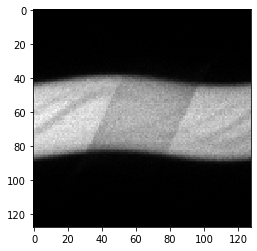

In [11]:
sinogram = pd.dcmread(projections_path)
sinogram_array = sinogram.pixel_array
sinogram_array = sinogram_array[:,71,:]
sinogram_array = sinogram_array[:128,:]
sinogram_array = sinogram_array.swapaxes(0,1)
plt.imshow(sinogram_array, cmap="gray")


Program first calls for wiener_filter_projections function which returns filtered projections. That is accomplished first by padding a projection array with zeros, thus increasing the matrix size. 
Image padding is followed by image centering which centers the image histogram so that it is simmetric with respect to histogram origin (zero). Result is shown below:


Text(0.5, 1.0, 'image_array_padded and centered')

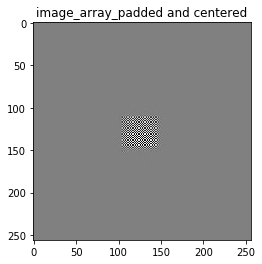

In [12]:
plt.imshow(image_array_padded_global, cmap="gray")
plt.title("image_array_padded and centered")

 After image centering, the 2dim Fourier Transform is computed which is then filtered using a wiener filter. Below is wiener filter and 2D FT of padded and centered image.

Text(0.5, 1.0, 'wiener_global-log scale')

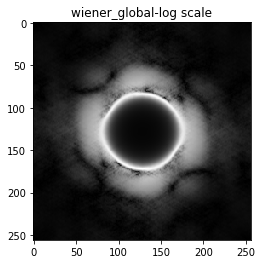

In [13]:
plt.imshow(np.log(1+np.abs(wiener_global)), cmap="gray")
plt.title("wiener_global-log scale")

Text(0.5, 1.0, '2D FT of padded and centered image:')

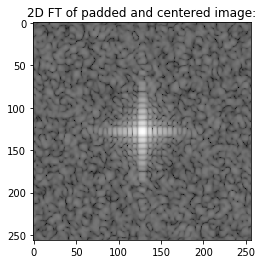

In [14]:
plt.imshow(np.log(1+np.abs(np.fft.fft2(image_array_centered))), cmap="gray")
plt.title("2D FT of padded and centered image:")

Filtering is accomplished with point-by-point multiplication. After retruning the result to real space, output for first projection is shown below: 

Text(0.5, 1.0, 'image_filtered_global')

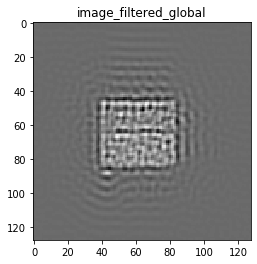

In [15]:
plt.imshow(image_filtered_global, cmap="gray")
plt.title("image_filtered_global")


Ringing artefact is here probably because I didn't yet include the filter apodisation.

The whole filtered sinogram looks like this:


Text(0.5, 1.0, 'filtered_sinogram_global')

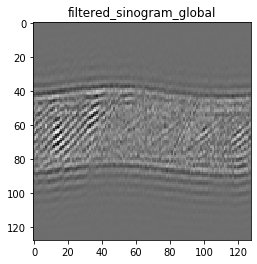

In [16]:
plt.imshow(filtered_sinogram_global, cmap="gray")
plt.title("filtered_sinogram_global")

This is the final result of reconstruction of cold rods section:

Text(0.5, 1.0, 'recon_image')

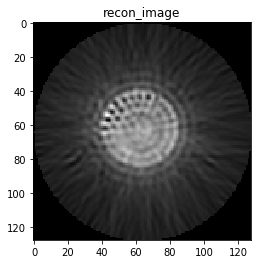

In [17]:
plt.imshow(reconstructed_img, cmap="gray")
plt.title("recon_image")